In [1]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.colors as mcolors
from scipy.stats import bootstrap
import random as rd
from file_helper import load_all_files
# sketchy way of figuring out if latex is installed, might fail.
# If it does, comment out
from distutils.spawn import find_executable
from itertools import cycle
import os
import pickle as pk


In [2]:
if find_executable('latex'):
    matplotlib.rcParams['text.usetex'] = True

font = {'family': 'normal',
        'weight': 'normal',
        'size': 12}


matplotlib.rc('font', **font)
cycle = list(mcolors.TABLEAU_COLORS.values())
print(cycle)


def get_color(i):
    if i >= len(cycle):
        return cycle[i % len(cycle)]
    else:
        return cycle[i]


def get_ci(trials):
    ci = bootstrap((trials,), np.mean, confidence_level=0.9, random_state=0)
    return ci.confidence_interval


def plot_stat(title, xlabel, ylabel):
    # my hunch is to wrap this in another for loop -- need to make sure it still runs without it
    # if there is only one m you want to work with, you need to provide a dictionary with that singe m in it -- constraint
    # print("x", x)
    # print("dict_y", dict_y)
    # put_on_plot(x, dict_y)

    SMALL_SIZE = 5
    matplotlib.rcParams.update({'font.size': 14})
    
    
    '''
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=5)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
    '''

    # idea to break this up here....
    # essentially invoke part 1 multiple times and then invoke part 2 as below
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(title)
    plt.close()

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [10]:
# x = [1,2,3] dict_y = {label:[[3,3,2],[4,5,4],[5,5,5]]}
def put_on_plot(x, dict_y, label_dict=None):
    for i, (key, val) in enumerate(dict_y.items()):
        if val:
            if label_dict is not None:
                key = label_dict[key]
            color = get_color(i)
            if type(val[0]) is list and len(val[0]) > 1:
                all_trials = val
                y = [np.mean(trials) for trials in all_trials]

                plt.plot(x, y, color=color, label=key)
                try:
                    all_ci = [get_ci(trials) for trials in all_trials]
                    ci_over = [ci.high for i, ci in enumerate(all_ci)]
                    ci_under = [ci.low for i, ci in enumerate(all_ci)]
                    plt.fill_between(x, ci_under, ci_over, color=color, alpha=.1)
                except:
                    print('couldnt do the ci', all_trials[0])
            else:
                print(x)
                print(val)
                plt.plot(x, val, color=color, label=key)
    
    plt.xticks(x, [str(i) for i in x])

In [12]:

def put_plot_rank(filepath, x, dict_y, label_dict=None):
    # set width of bar
    barWidth = 0.2
    position = np.arange(len(list(dict_y.keys())))
    who_passed = [1 for _ in position]
    for j, B in enumerate(x):
        color = get_color(j)
        position = [i + barWidth for i in position]
        fraction_test_passed = list([1 - np.mean(val[j])
                                    for val in dict_y.values()])
        who_passes = []
        for k, previously in enumerate(who_passed):
            if fraction_test_passed[k] > previously:
                who_passes.append(previously)
            else:
                who_passes.append(fraction_test_passed[k])

        plt.bar(position, who_passes, color=color, width=barWidth,
                edgecolor='grey', label=r'k='+str(B))
        who_passed = who_passes
    plt.xticks([r + barWidth for r in range(len(list(dict_y.keys())))],
               list(dict_y.keys()), fontsize=18)
    import matplotlib.font_manager as font_manager
    # Adding Xticks
    plt.xlabel('Generative models', fontsize=18)
    plt.ylabel('Percentage of trials that passed', fontsize=18)

    font = font_manager.FontProperties(style='normal', size=18)
    plt.legend(prop=font)
    plt.tight_layout()
    plt.show()
    plt.close()

In [13]:
path_dir = 'results'
list_files = load_all_files(path_dir)


/home/floregol/miniconda3/lib/python3.9/site-packages/scipy/stats/_bootstrap.py:100: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = num / den


couldnt do the ci [-0.39999999999999997, -0.6, -0.6, -0.6, -0.39999999999999997, -0.6, -0.6, -0.39999999999999997, -0.39999999999999997, -0.6]


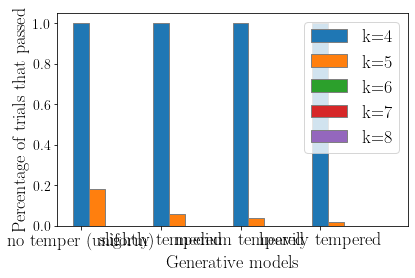

No handles with labels found to put in legend.


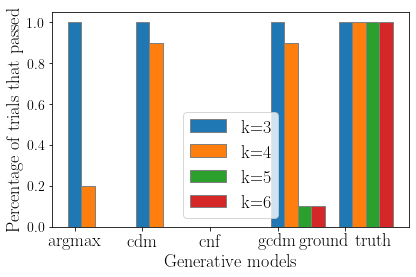

No handles with labels found to put in legend.


couldnt do the ci [0.24999999999770842, 0.24999999999770842]
couldnt do the ci [0.24999999999770842, 0.24999999999770842]
couldnt do the ci [0.24999999999770842, 0.24999999999770842]


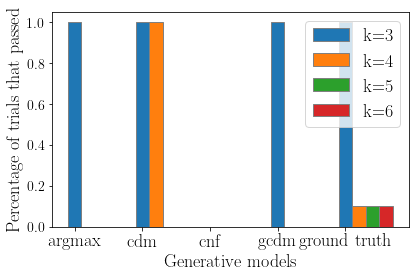

No handles with labels found to put in legend.


couldnt do the ci [-0.39999999999999997, -0.6]
couldnt do the ci [0.19999999999999998, -0.19999999999999998]
couldnt do the ci [1.0, 1.0]


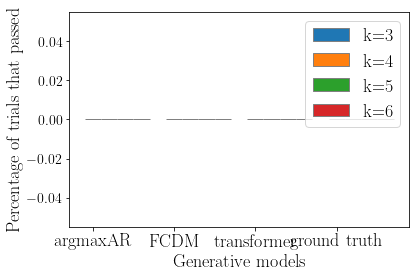

No handles with labels found to put in legend.


In [14]:

for file in list_files:
    file_name = file.split('.')[0]
    with open(os.path.join(path_dir, file), 'rb') as f:  # load the data
            data = pk.load(f)
    tokens = file.split('_')
    prefix = tokens[:6]
    type_file = tokens[6:]
    type_file = type_file[:-1] + [type_file[-1].split('.')[0]]
    
    if type_file[0] == 'ranking':
        put_on_plot(data['x'], data['data'], data['label_dict'])
        plot_stat(os.path.join('figures',file_name+'.pdf'), r'granularity level $k$', r'Kendall rank correlation coefficient')

    elif type_file[0] == 'S':
        put_on_plot(data['x'], data['data'])
        plot_stat(os.path.join('figures',file_name+'.pdf'), 'Bins', 'algo')
    elif type_file[0] == 'hypothesis':
        put_plot_rank(os.path.join('figures',file_name+'.pdf'), data['x'], data['data'])
        plot_stat(os.path.join('figures',file_name+'.pdf'), 'Bins', 'algo')
        
   